<a href="https://colab.research.google.com/github/PisutSukpool/BADS7105-CRM-analytics-and-intelligence/blob/main/Homework%2007/Product_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta 
from datetime import datetime,date   
from matplotlib.ticker import PercentFormatter
import copy
import matplotlib as mpl

df = pd.read_csv('/content/drive/My Drive/BADS_NIDA/CRM/hw7_product_recommendation/survey_product_recommendation.csv')
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font',family='TH Sarabun New',size=20)

df.head()

,ประทับเวลา,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
0,3/20/2021 11:53:45,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย
1,3/20/2021 11:54:01,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย
2,3/20/2021 11:54:05,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย
3,3/20/2021 11:54:13,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย
4,3/20/2021 11:54:18,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,NaN,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย


In [21]:
mapper = {'เคย' : 1 ,'ไม่เคย' : 0 }
df_encode = df.replace(mapper)
df_encode = df_encode.drop(columns=['ประทับเวลา'])
df_encode_fillna = df_encode.fillna(0)
df_encode_fillna.head()

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,1,1.0,0,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,1,1,0.0,1,0,0,0.0,0,0,0,0.0,0,0.0,0,0,1,1,1
1,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,0,1,1,1,0,1.0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1.0,1,1,0,1.0,0,1,0,0.0,0,1.0,1,0,1,0,1
2,1,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,1,1,0,1,1,0,1,1.0,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1.0,1,0,1,0.0,0,1,0,0.0,0,0.0,1,0,1,1,1
3,0,0,0,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1.0,0,0,0,0,1,0,1,1,0,1,0,1,1,0,1,0,0,1,0,0.0,1,0,0,0.0,1,0,0,0.0,0,0.0,0,0,0,0,1
4,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,1.0,0,0,0,1,0,0,1,1,0,1,1,0,1,0,0,1,0,0,0,0.0,1,0,1,0.0,0,0,0,1.0,0,0.0,1,0,1,1,1


In [22]:
df_item = df_encode_fillna
df_profile = df_item.melt(var_name="Product", value_name="Sum")
df_sum = df_profile.groupby(['Product']).sum().reset_index()
df_sum_sort = df_sum.sort_values(by = ['Sum'], ascending=[False])
df_sum_sort.head(10)

,Product,Sum
17,ครีมกันแดด,46.0
10,กระเป๋า,46.0
22,ชาบู,46.0
56,โรตี,44.0
13,กะหรี่(ปั๊บ),43.0
49,เม็ดมะม่วงหิมพานต์,42.0
34,หมอนข้าง,40.0
53,แฟน ที่แปลว่าพัดลม,37.0
36,หมูแดดเดียว,37.0
6,Software ถูกลิขสิทธิ์,36.0


# **Most Popular**

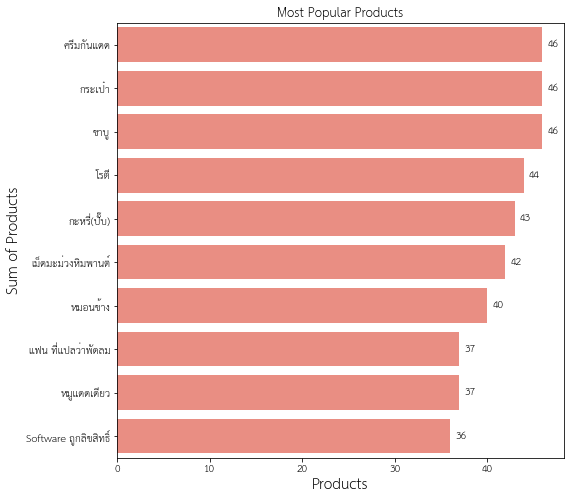

In [23]:
mpl.rcParams.update({'font.size': 10})
plt.figure(figsize=(8, 8))

ax = sns.barplot(y="Product", x="Sum", data=df_sum_sort.head(10),color="salmon",orient="h")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")  
plt.xlabel("Products", size=14)
plt.ylabel("Sum of Products", size=14)
plt.title("Most Popular Products")
plt.show()

# **Recommendation Engine Item Based**

cosine similarity

In [64]:
df_item_based_cos = pd.DataFrame(index=df_encode_fillna.columns,columns=df_encode_fillna.columns)
from scipy.spatial.distance import cosine
for i in range(0,len(df_item_based_cos.columns)) :
    for j in range(0,len(df_item_based_cos.columns)) :

      df_item_based_cos.iloc[i,j] = round(1-cosine(df_encode_fillna.iloc[:,i],df_encode_fillna.iloc[:,j])  ,2)
df_item_based_cos.head()

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
จักรยานเสือภูเขา,1,0.55,0.34,0.4,0.42,0.27,0.25,0.46,0.45,0.12,0.1,0.52,0.59,0.58,0.22,0.38,0.53,0.6,0.53,0.22,0.19,0.66,0.55,0.54,0.45,0.31,0.35,0.38,0.3,0.57,0.47,0.59,0.59,0.43,0.42,0.38,0.4,0.54,0.58,0.27,0.34,0.42,0.53,0.18,0.47,0.6,0.42,0.4,0.38,0.1,0.47,0.43,0.34,0.31,0.09,0.47,0.38,0.46,0.58,0.59
คอลลาเจน,0.55,1,0.27,0.32,0.53,0.14,0.2,0.46,0.36,0.4,0.16,0.66,0.66,0.61,0.45,0.3,0.73,0.71,0.62,0.4,0.38,0.68,0.6,0.54,0.62,0.33,0.28,0.6,0.48,0.59,0.38,0.74,0.74,0.23,0.48,0.6,0.32,0.71,0.46,0.35,0.36,0.33,0.52,0.14,0.44,0.75,0.47,0.51,0.52,0.24,0.57,0.35,0.36,0.24,0.28,0.61,0.4,0.66,0.7,0.74
Brownie อวกาศ,0.34,0.27,1,0.48,0.45,0.63,0.67,0.1,0.13,0.22,0.37,0.39,0.28,0.32,0.2,0.34,0.34,0.42,0.37,0.26,0.17,0.34,0.36,0.4,0.29,0.37,0.32,0.13,0.27,0.31,0.17,0.33,0.33,0.26,0.25,0.11,0.42,0.35,0.35,0.32,0.2,0.6,0.21,0.32,0.28,0.34,0.3,0.14,0.29,0.37,0.21,0.52,0.8,0.55,0.16,0.32,0.45,0.24,0.37,0.33
แม่โขง,0.4,0.32,0.48,1,0.27,0.57,0.4,0.37,0.24,0.13,0.44,0.56,0.51,0.43,0.12,0.87,0.57,0.4,0.53,0.31,0.3,0.45,0.43,0.58,0.57,0.33,0.19,0.24,0.4,0.51,0.2,0.55,0.55,0.15,0.4,0.07,0.51,0.58,0.28,0.28,0.24,0.45,0.57,0.19,0.17,0.56,0.36,0,0.35,0.33,0.38,0.46,0.36,0.22,0.19,0.44,0.27,0.39,0.4,0.55
Botox,0.42,0.53,0.45,0.27,1,0.24,0.33,0.23,0.3,0.17,0.14,0.35,0.37,0.3,0.75,0.25,0.41,0.31,0.49,0.29,0.38,0.5,0.33,0.36,0.33,0.14,0.24,0.4,0.4,0.35,0.25,0.44,0.44,0.19,0.19,0.33,0.32,0.41,0.26,0.24,0.3,0.33,0.31,0.24,0.42,0.45,0.33,0.32,0.36,0.14,0.24,0.19,0.6,0.41,0.12,0.39,0.17,0.3,0.5,0.44


In [65]:
pairs_cos = df_item_based_cos.stack().reset_index()
pairs_cos.columns = ['Pair1', 'Pair2','Value']
pairs_cos_filtered=pairs_cos.loc[ (pairs_cos['Value'] > 0.9) & (pairs_cos['Pair1'] != pairs_cos['Pair2']) ]
pairs_cos_filtered = pairs_cos_filtered.drop(pairs_cos_filtered[pairs_cos_filtered.Value < 0.8].index)
pairs_cos_filtered = pairs_cos_filtered.sort_values(by='Value',ascending=False)

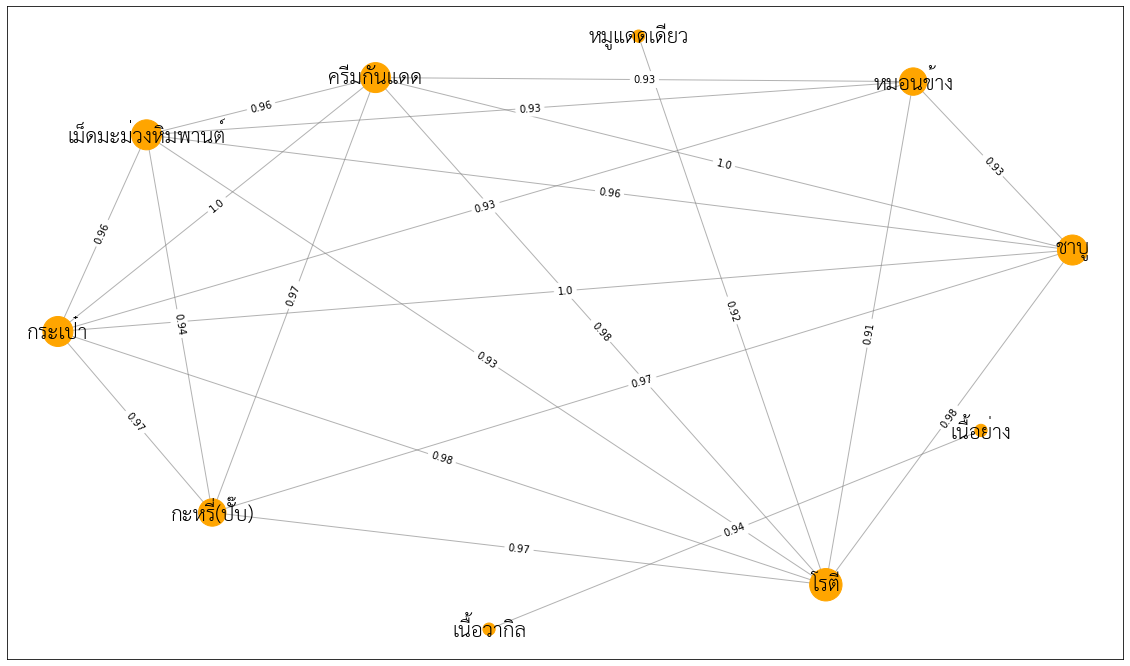

In [66]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.from_pandas_edgelist(pairs_cos_filtered, 'Pair1', 'Pair2',edge_attr='Value')
pos = nx.spring_layout(G,k=500)
d = dict(G.degree)

plt.figure(3,figsize=(20,12))
nx.draw_networkx_nodes(G, pos,nodelist=d.keys(), node_size=[v * 150 for v in d.values()] ,node_color='orange')
nx.draw_networkx_labels(G, pos,font_family='TH Sarabun New',font_size=20)
nx.draw_networkx_edges(G = G, pos = pos, edge_color='gray', alpha=0.6,)
edge_labels = nx.get_edge_attributes(G, "Value")
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.show()


# **Recommendation Engine User Based**

In [27]:
df_encode_fillna.head()
df_user = df_encode_fillna
df_used = df_user.stack().reset_index()
df_used.columns = ['user_id','product','count']
df_used.head()

,user_id,product,count
0,0,จักรยานเสือภูเขา,0.0
1,0,คอลลาเจน,0.0
2,0,Brownie อวกาศ,0.0
3,0,แม่โขง,0.0
4,0,Botox,0.0


In [28]:
mean = df_used.groupby(by="user_id",as_index=False)['count'].mean()
df_used_avg = pd.merge(df_used,mean,on='user_id')
df_used_avg['adg_count']=df_used_avg['count_x']-df_used_avg['count_y']
df_used_avg.head()

,user_id,product,count_x,count_y,adg_count
0,0,จักรยานเสือภูเขา,0.0,0.316667,-0.316667
1,0,คอลลาเจน,0.0,0.316667,-0.316667
2,0,Brownie อวกาศ,0.0,0.316667,-0.316667
3,0,แม่โขง,0.0,0.316667,-0.316667
4,0,Botox,0.0,0.316667,-0.316667


In [29]:
from sklearn.metrics.pairwise import cosine_similarity
final=pd.pivot_table(df_used_avg,values='adg_count',index='user_id',columns='product')
final.head()

product,Board game,Botox,Brownie อวกาศ,Lego,Omakase,PS5,Software ถูกลิขสิทธิ์,Surfskate,drone,กรรไกรตัดขนจมูก,กระเป๋า,กระเป๋า chanel,กะปิดอง,กะหรี่(ปั๊บ),กัญชง,กัญชา,ข้าวขาหมูคากิคาจักออนไลน์,ครีมกันแดด,คอร์ส bikini wax,คอร์สโบท็อกกราม,คอลลาเจน,จักรยานเสือภูเขา,ชาบู,ชุดนอนไม่ได้นอน,ชุดน้องหมา,ตาชั่ง,ต้นไม้ประดับห้อง,ถั่งเช่า,ที่ยกน้ำหนัก (Dumbell),น้องหมา,น้ำส้มดีโด้,บัตตาเลี่ยนที่ตัดผม,มะม่วงเบา,ยาดอง,หมอนข้าง,หมอนสุขภาพสำหรับคนนอนไม่หลับ,หมูแดดเดียว,หลอดไฟเปลี่ยนสีได้,ห้องน้ำแมวอัตโนมัติ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,เกมส์ FIFA Online,เก้าอี้นวดไฟฟ้า,เครื่องดูดฝุ่นอัตโนมัติ (robot),เครื่องตรวจน้ำตาลในเลือด,เครื่องทำลายเอกสาร,เครื่องย่อยเศษอาหาร,เครื่องวัดความดัน,เนื้อย่าง,เนื้อวากิล,เม็ดมะม่วงหิมพานต์,เสื้อซีทรู,แผ่นเสียง,แพ็คเกจไทยเที่ยวไทย,แฟน ที่แปลว่าพัดลม,แม่โขง,แสงโสม,โรตี,ไดร์เป่าผม Dyson,ไพ่ยิปซี,ไฟอัจฉริยะ
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.683333,-0.316667,-0.316667,0.683333,0.683333,0.683333,0.683333,-0.316667,-0.316667,0.683333,0.683333,-0.316667,-0.316667,0.683333,-0.316667,-0.316667,-0.316667,0.683333,-0.316667,-0.316667,-0.316667,-0.316667,0.683333,-0.316667,-0.316667,-0.316667,-0.316667,-0.316667,-0.316667,-0.316667,0.683333,-0.316667,-0.316667,-0.316667,0.683333,-0.316667,0.683333,-0.316667,-0.316667,-0.316667,-0.316667,-0.316667,0.683333,-0.316667,-0.316667,-0.316667,-0.316667,0.683333,0.683333,0.683333,-0.316667,-0.316667,-0.316667,0.683333,-0.316667,-0.316667,0.683333,-0.316667,-0.316667,-0.316667
1,-0.450000,-0.450000,-0.450000,-0.450000,-0.450000,-0.450000,-0.450000,-0.450000,-0.450000,0.550000,0.550000,-0.450000,0.550000,0.550000,-0.450000,-0.450000,-0.450000,0.550000,-0.450000,-0.450000,0.550000,-0.450000,0.550000,0.550000,-0.450000,0.550000,-0.450000,0.550000,0.550000,-0.450000,0.550000,-0.450000,0.550000,-0.450000,0.550000,0.550000,0.550000,-0.450000,-0.450000,-0.450000,-0.450000,-0.450000,0.550000,0.550000,-0.450000,-0.450000,0.550000,-0.450000,-0.450000,0.550000,0.550000,-0.450000,0.550000,0.550000,0.550000,0.550000,0.550000,-0.450000,0.550000,-0.450000
2,0.450000,-0.550000,-0.550000,0.450000,-0.550000,-0.550000,0.450000,0.450000,0.450000,-0.550000,0.450000,-0.550000,-0.550000,0.450000,-0.550000,-0.550000,-0.550000,0.450000,-0.550000,-0.550000,-0.550000,0.450000,0.450000,0.450000,0.450000,0.450000,0.450000,-0.550000,0.450000,0.450000,0.450000,0.450000,0.450000,-0.550000,0.450000,0.450000,0.450000,0.450000,-0.550000,-0.550000,-0.550000,-0.550000,-0.550000,0.450000,0.450000,-0.550000,0.450000,0.450000,0.450000,0.450000,0.450000,-0.550000,-0.550000,0.450000,-0.550000,-0.550000,0.450000,-0.550000,-0.550000,0.450000
3,0.583333,-0.416667,-0.416667,0.583333,0.583333,-0.416667,-0.416667,-0.416667,-0.416667,0.583333,0.583333,-0.416667,-0.416667,0.583333,-0.416667,0.583333,-0.416667,0.583333,-0.416667,-0.416667,-0.416667,-0.416667,0.583333,-0.416667,-0.416667,0.583333,0.583333,-0.416667,-0.416667,-0.416667,-0.416667,0.583333,-0.416667,0.583333,0.583333,-0.416667,0.583333,-0.416667,-0.416667,-0.416667,0.583333,0.583333,0.583333,-0.416667,-0.416667,-0.416667,-0.416667,0.583333,0.583333,0.583333,-0.416667,-0.416667,-0.416667,0.583333,0.583333,0.583333,0.583333,-0.416667,-0.416667,-0.416667
4,0.616667,0.616667,-0.383333,-0.383333,-0.383333,-0.383333,0.616667,-0.383333,-0.383333,-0.383333,0.616667,0.616667,-0.383333,0.616667,-0.383333,-0.383333,-0.383333,0.616667,-0.383333,0.616667,0.616667,-0.383333,0.616667,-0.383333,0.616667,-0.383333,0.616667,-0.383333,0.616667,0.616667,0.616667,-0.383333,-0.383333,-0.383333,-0.383333,0.616667,0.616667,-0.383333,-0.383333,-0.383333,-0.383333,-0.383333,0.616667,-0.383333,-0.383333,-0.383333,-0.383333,-0.383333,-0.383333,0.616667,-0.383333,-0.383333,-0.383333,0.616667,-0.383333,-0.383333,0.616667,0.616667,0.616667,-0.383333


In [30]:
cosine = cosine_similarity(final)
np.fill_diagonal(cosine, 0 )
similarity_with_product =pd.DataFrame(cosine,index=final.index)
similarity_with_product.columns=final.index
similarity_with_product.head()

user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.248464,0.327684,0.587447,0.347579,0.442100,0.494962,0.286630,0.442100,0.460847,0.517143,0.506695,0.522992,0.682629,0.582699,0.494962,0.541199,0.476996,0.568653,0.326761,0.480723,0.189500,0.253347,0.320482,0.424696,0.568653,0.582699,0.344644,0.541199,0.392500,0.446583,0.421328,0.492563,0.582699,0.446583,0.224078,0.568653,0.465773,0.424413,0.326761,0.514773,0.416947,0.512296,0.442100,0.460847,0.429987
1,0.248464,0.000000,0.212121,0.186871,0.251501,0.458682,0.458215,0.385264,0.390730,0.248464,0.251446,0.355335,0.250143,0.328813,0.355335,0.458215,0.423982,0.249344,0.320406,0.460057,0.136364,-0.026021,0.426401,0.191919,0.418793,0.320406,0.284268,0.358313,0.218829,0.057239,0.546438,0.443203,0.285112,0.213201,0.249057,0.186871,0.251501,0.385264,0.101845,0.530295,0.594588,0.425919,0.362620,0.118918,0.248464,0.220847
2,0.327684,0.212121,0.000000,0.152894,0.230830,0.560612,0.506448,0.284761,0.356753,0.471721,0.367497,0.355335,0.561131,0.444865,0.568535,0.368639,0.465012,0.523271,0.368639,0.312558,0.242424,-0.048324,0.284268,0.481481,0.231759,0.506448,0.284268,0.250143,0.465012,0.077441,0.345706,0.362620,0.445945,0.426401,0.494396,0.356753,0.437544,0.368514,0.179106,0.172082,0.220847,0.182537,0.510355,0.220847,0.471721,0.322777
3,0.587447,0.186871,0.152894,0.000000,0.098503,0.382857,0.376630,0.422577,0.382857,0.369426,0.292770,0.621519,0.261516,0.448914,0.406378,0.307098,0.345033,0.230350,0.654756,0.159473,0.254824,0.156296,0.023905,0.118918,0.294045,0.515693,0.693233,0.216035,0.414039,0.458682,0.218814,0.248465,0.258199,0.621519,0.293836,0.177143,0.376630,0.253546,0.549297,0.301227,0.588571,0.420699,0.429166,0.520000,0.369426,0.371429
4,0.347579,0.251501,0.230830,0.098503,0.000000,0.376630,0.435958,0.291376,0.307098,0.347579,0.178122,0.169675,0.412755,0.415618,0.533265,0.294947,0.405843,0.212015,0.224442,0.571362,0.299735,0.191449,0.412068,0.458215,0.251011,0.435958,0.315111,0.348190,0.475815,0.113692,0.493203,0.256525,0.381501,0.242393,0.417131,0.237566,0.294947,0.462774,0.147332,0.283884,0.237566,0.209836,0.293171,0.237566,0.347579,0.179623


In [31]:
#top_user = similarity_with_product.stack()
trx=[]
top_user = similarity_with_product.stack().rename_axis([*similarity_with_product.index.names, "var_name"]).rename("value")
check=top_user.to_frame()
for ind , col in check.iterrows():
  trx.append([ind[0],ind[1],col[0]])
#pd.melt(check.reset_index(), id_vars=['user_1', 'user_2'], value_name='value')
#check.user_id.ffill(inplace=True)

In [54]:
pair_user = pd.DataFrame(trx, columns = ['Pair1', 'Pair2','Value']) 
pair_user['Value'] = round(pair_user['Value'],2)
pair_user=pair_user.loc[ (pair_user['Value'] > 0.65) & (pair_user['Pair1'] != pair_user['Pair2']) ]
pair_user = pair_user.drop(pair_user[pair_user.Value < 0.6].index)
pair_user = pair_user.sort_values(by='Value',ascending=False)
pair_user.head(20)

,Pair1,Pair2,Value
2033,44,9,1.00
458,9,44,1.00
839,18,11,0.75
1164,25,14,0.75
669,14,25,0.75
524,11,18,0.75
623,13,25,0.73
1163,25,13,0.73
631,13,33,0.73
1531,33,13,0.73


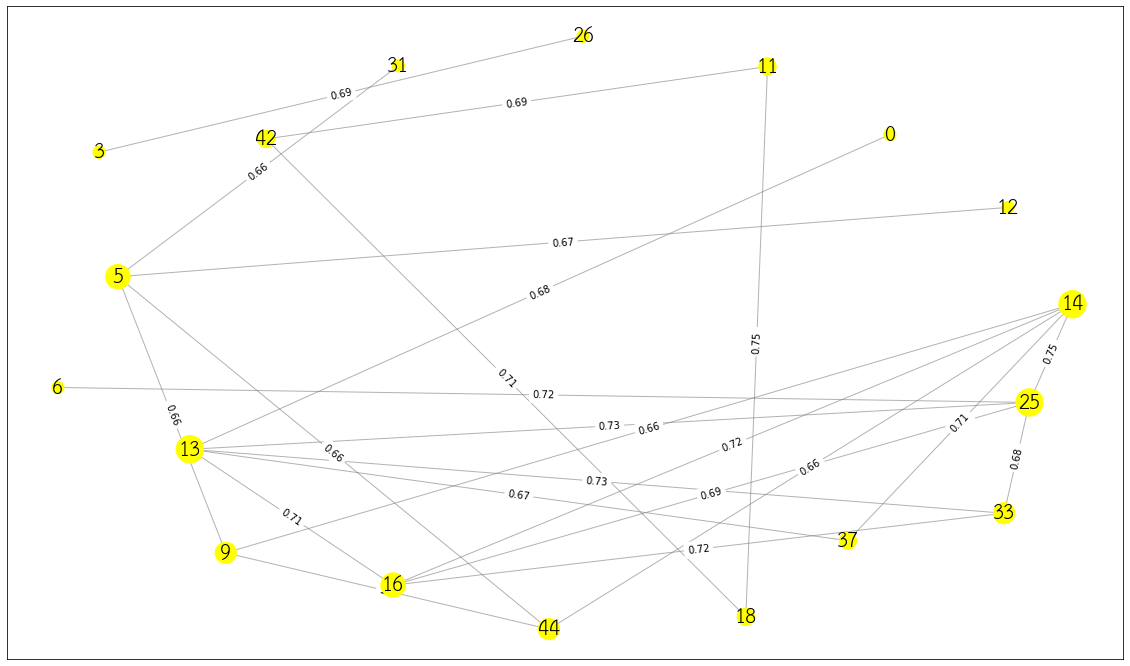

In [55]:
G=nx.from_pandas_edgelist(pair_user, 'Pair1', 'Pair2', edge_attr='Value')
pos = nx.spring_layout(G,k=500)
d = dict(G.degree)
plt.figure(3,figsize=(20,12))
nx.draw_networkx_nodes(G, pos,nodelist=d.keys(), node_size=[v * 150 for v in d.values()] ,node_color='yellow')
nx.draw_networkx_labels(G, pos,font_family='TH Sarabun New',font_size=20)
nx.draw_networkx_edges(G = G, pos = pos, edge_color='gray', alpha=0.6)
edge_labels = nx.get_edge_attributes(G, "Value")
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.show()